Dataset loaded: 683 samples, 9 features
Class distribution: Benign=444, Malignant=239

Train set: 547 samples
Test set: 136 samples

Training Models

Training Decision Tree...

Decision Tree:
  Accuracy: 92.65%
  Precision: 90.20%
  Recall: 90.20%
  F1-Score: 90.20%
  Confusion Matrix:
    TN:  80  FP:   5
    FN:   5  TP:  46

Training SVM...

SVM:
  Accuracy: 94.85%
  Precision: 90.74%
  Recall: 96.08%
  F1-Score: 93.33%
  Confusion Matrix:
    TN:  80  FP:   5
    FN:   2  TP:  49

Training Neural Network...

Neural Network:
  Accuracy: 96.32%
  Precision: 91.07%
  Recall: 100.00%
  F1-Score: 95.33%
  Confusion Matrix:
    TN:  80  FP:   5
    FN:   0  TP:  51

Model              Accuracy
-------------------------
Decision Tree   92.65%
SVM             94.85%
Neural Network  96.32%


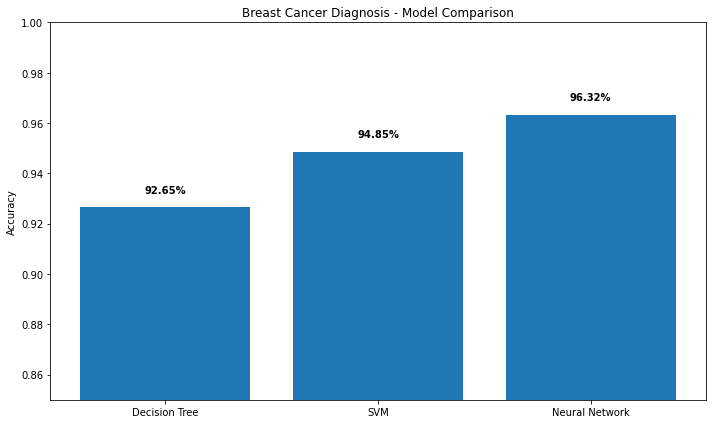


Best Model: Neural Network with 96.32% accuracy
Sample Predictions:

Actual |DecisionTree|SVM|NeuralNetwork
-------------------------
Malignant | M  | M   | M 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Malignant | M  | M   | M 
Malignant | M  | M   | M 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | B  | M   | M 
Malignant | M  | M   | M 
Malignant | M  | M   | M 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | B  | B   | B 
Benign   | M  | M   | M 
Benign   | B  | B   | B 
Malignant | M  | M   | M 
Benign   | B  | B   | B 
Malignant | M  | M   | M 
Malignant | M  | M   | M 
Benign   | B  | B   | B 
Malignant | M  | M   | M 
Malignant | M  | M   | M 
Malignant | M  | M   | M 
Benign   | B  | B   | B 
Malignant | M  | M   | M 
Benign   | B  | B   | B 
Malignant | M  | M   | M 
Be

In [4]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt


def load_data(dataset):
    column = [
        'ID', 'Clump_Thickness', 'Uniformity_of_Cell_Size', 
        'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 
        'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 
        'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class'
    ]
    
    data = []
    with open(dataset, 'r') as f:
        for line in f:
            values = line.strip().split(',')
            if '?' not in values:
               
                row = [float(val) if i != 0 else int(val) for i, val in enumerate(values)]
                data.append(row)
    
    df = pd.DataFrame(data, columns=column)
    return df



df = load_data('breast-cancer-wisconsin.data')


X = df.drop(['ID', 'Class'], axis=1).values
y = df['Class'].values

y_new = np.zeros_like(y)

for i in range(len(y)):
    if y[i] == 2:
        y_new[i] = 0
    else:
        y_new[i] = 1
y = y_new

print(f"Dataset loaded: {len(X)} samples, {X.shape[1]} features")
print(f"Class distribution: Benign={sum(y==0)}, Malignant={sum(y==1)}")



def train_test_split_simple(X, y, test_size=0.2):
    
    
    n_test = int(len(X) * test_size)

    indx = np.random.permutation(len(X))
    
    test_indices = indx[:n_test]      
    train_indices = indx[n_test:]     
    
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_simple(X, y, test_size=0.2)
print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


def Normalization(X_train, X_test):

    mean = np.mean(X_train, axis=0)
    standard_dv = np.std(X_train, axis=0)
    
    for i in range(len(standard_dv)):
        if standard_dv[i] == 0:
            standard_dv[i] = 1
        
           

    X_train2 = (X_train - mean) / standard_dv
    X_test2 = (X_test - mean) / standard_dv
    
    return X_train2, X_test2

X_train, X_test = Normalization(X_train, X_test)



class Node:
    
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx 
        self.threshold = threshold      
        self.left = left                
        self.right = right              
        self.value = value            


class DecisionTree:
    
    
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    def _gini(self, y):
     
        if len(y) == 0:
            return 0
        p1 = np.sum(y == 1) / len(y)
        p0 = 1 - p1
        return 1 - (p0**2 + p1**2)
    
    def _best_split(self, X, y):
       
        best_gini = float('inf')
        best_split = {}
        
        n_samples, n_features = X.shape
        
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)
            
            for threshold in unique_values:
                
                left_mask = feature_values <= threshold
                right_mask = feature_values > threshold
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
               
                gini_left = self._gini(y[left_mask])
                gini_right = self._gini(y[right_mask])
                
                
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                weighted_gini = (n_left * gini_left + n_right * gini_right) / (n_left + n_right)
                
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_split = {'feature_idx': feature_idx,'threshold': threshold,'left_mask': left_mask,'right_mask': right_mask
                    }
        
        return best_split if best_split else None
    
    def _build_tree(self, X, y, depth=0):
        
        n_samples = len(y)
        
        
        if (depth >= self.max_depth or n_samples < self.min_samples_split or len(np.unique(y)) == 1):
            
            count_class1 = np.sum(y == 1)
            count_class0 = np.sum(y == 0)

            if count_class1 > count_class0:
                value = 1
    
            else:
                value = 0
    
            return Node(value=value)
        
        
        split = self._best_split(X, y)
        
        if split is None:
            
            countclass1 = np.sum(y == 1)
            countclass0 = np.sum(y == 0)

            if countclass1 > countclass0:
                value = 1
    
            else:
                value = 0
            
            return Node(value=value)
        
        # ساخت زیردرخت‌ها
        left_subtree = self._build_tree(
            X[split['left_mask']], 
            y[split['left_mask']], 
            depth + 1
        )
        
        right_subtree = self._build_tree(
            X[split['right_mask']], 
            y[split['right_mask']], 
            depth + 1
        )
        
        return Node(
            feature_idx=split['feature_idx'],
            threshold=split['threshold'],
            left=left_subtree,
            right=right_subtree
        )
    
    def fit(self, X, y):
       
        self.root = self._build_tree(X, y)
    
    def _predict_sample(self, x, node):
        if node.value is not None:  
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])

     

class SimpleSVM:
   
    
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
    
    def fit(self, X, y):
       
        n_samples, n_features = X.shape
        
        y_ = []
        for label in y:
            if label <= 0:
                y_.append(-1)
            else:
                y_.append(1)
        y_ = np.array(y_)
        

        self.w = np.zeros(n_features)
        self.b = 0
        
       
        for iteration in range(self.n_iters):
            for i in range(len(X)):
                current_x = X[i]
                current_y = y_[i]     
        
                
                distance = np.dot(current_x, self.w) - self.b
                margin = current_y * distance
        
                if margin >= 1:
                    self.w = self.w - self.lr * 2 * self.lambda_param * self.w
                         
                else:
           
                    self.w = self.w - self.lr * (2 * self.lambda_param * self.w - current_y * current_x)
                    self.b = self.b - self.lr * current_y
    
    def predict(self, X):
        
        linear_output = np.dot(X, self.w) - self.b
        return np.where(linear_output >= 0, 1, 0)



class NeuralNetwork2Hidden:

    
    def __init__(self, layer1=7, layer2=5, lr=0.01, epochs=500):
        self.layer1 = layer1
        self.layer2 = layer2
        self.lr = lr
        self.epochs = epochs
        self.weights = {}
        self.biases = {}
    
    def fit(self, X, y):
       
        n_samples, n_features = X.shape
        
        np.random.seed(42)
        
        
        self.weights['W1'] = 0.1 * np.random.randn(n_features, self.layer1)
        self.biases['b1'] = np.zeros((1, self.layer1))
        
        
        self.weights['W2'] = 0.1 * np.random.randn(self.layer1, self.layer2)
        self.biases['b2'] = np.zeros((1, self.layer2))
        
        self.weights['W3'] = 0.1 * np.random.randn(self.layer2, 1)
        self.biases['b3'] = np.zeros((1, 1))
        
        y = y.reshape(-1, 1)
        
        
        for epoch in range(self.epochs):
            
            z1 = np.dot(X, self.weights['W1']) + self.biases['b1']
            a1 = 1 / (1 + np.exp(-z1))
            
            z2 = np.dot(a1, self.weights['W2']) + self.biases['b2']
            a2 = 1 / (1 + np.exp(-z2))
            
            z3 = np.dot(a2, self.weights['W3']) + self.biases['b3']
            a3 = 1 / (1 + np.exp(-z3))
            
            error = a3 - y
            
            
            dz3 = error * a3 * (1 - a3)
            dW3 = np.dot(a2.T, dz3)
            db3 = np.sum(dz3, axis=0)
            
            da2 = np.dot(dz3, self.weights['W3'].T)
            dz2 = da2 * a2 * (1 - a2)
            dW2 = np.dot(a1.T, dz2)
            db2 = np.sum(dz2, axis=0)
            
            da1 = np.dot(dz2, self.weights['W2'].T)
            dz1 = da1 * a1 * (1 - a1)
            dW1 = np.dot(X.T, dz1)
            db1 = np.sum(dz1, axis=0)
            
            self.weights['W1'] -= self.lr * dW1
            self.biases['b1'] -= self.lr * db1
            self.weights['W2'] -= self.lr * dW2
            self.biases['b2'] -= self.lr * db2
            self.weights['W3'] -= self.lr * dW3
            self.biases['b3'] -= self.lr * db3
    
    def predict(self, X):
        
        z1 = np.dot(X, self.weights['W1']) + self.biases['b1']
        a1 = 1 / (1 + np.exp(-z1))
        
        z2 = np.dot(a1, self.weights['W2']) + self.biases['b2']
        a2 = 1 / (1 + np.exp(-z2))
    
        z3 = np.dot(a2, self.weights['W3']) + self.biases['b3']
        a3 = 1 / (1 + np.exp(-z3))
        
        return (a3 > 0.5).astype(int).flatten()
    


def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TN, FP], [FN, TP]])

def print_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    TP, FP, FN, TN = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{model_name}:")
    print(f"  Accuracy: {acc:.2%}")
    print(f"  Precision: {precision:.2%}")
    print(f"  Recall: {recall:.2%}")
    print(f"  F1-Score: {f1:.2%}")
    print(f"  Confusion Matrix:")
    print(f"    TN: {TN:3d}  FP: {FP:3d}")
    print(f"    FN: {FN:3d}  TP: {TP:3d}")
    
    return acc



print("\n" + "="*50)
print("Training Models")
print("="*50)

# آموزش درخت تصمیم
print("\nTraining Decision Tree...")
dt_model = DecisionTree(max_depth=5)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_acc = print_metrics(y_test, dt_pred, "Decision Tree")

# آموزش SVM
print("\nTraining SVM...")
svm_model = SimpleSVM(learning_rate=0.001, n_iters=2000)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_acc = print_metrics(y_test, svm_pred, "SVM")

# آموزش شبکه عصبی
print("\nTraining Neural Network...")
nn_model = NeuralNetwork2Hidden(layer1=7,layer2=5,lr=0.01,epochs=1000)
nn_model.fit(X_train, y_train)
nn_pred = nn_model.predict(X_test)
nn_acc = print_metrics(y_test, nn_pred, "Neural Network")



models = ['Decision Tree', 'SVM', 'Neural Network']
accuracies = [dt_acc, svm_acc, nn_acc]

print("\nModel              Accuracy")
print("-" * 25)
for model, acc in zip(models, accuracies):
    print(f"{model:15s} {acc:.2%}")


plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies)
plt.ylim([0.85, 1.0])
plt.ylabel('Accuracy')
plt.title('Breast Cancer Diagnosis - Model Comparison')


for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


best_idx = np.argmax(accuracies)
print(f"\nBest Model: {models[best_idx]} with {accuracies[best_idx]:.2%} accuracy")



print("Sample Predictions:")

print("\nActual |DecisionTree|SVM|NeuralNetwork")
print("-" * 25)


np.random.seed(42)
sample_indices = np.random.choice(len(y_test), min(50, len(y_test)), replace=False)

for idx in sample_indices:
    actual = "Malignant" if y_test[idx] == 1 else "Benign"
    dt = "M" if dt_pred[idx] == 1 else "B"
    svm = "M" if svm_pred[idx] == 1 else "B"
    nn = "M" if nn_pred[idx] == 1 else "B"
    
    print(f"{actual:8s} | {dt:2s} | {svm:3s} | {nn:2s}")

print("\nM = Malignant, B = Benign")